  0% (0 of 10999) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (49 of 10999) |                     | Elapsed Time: 0:00:00 ETA:   0:00:22
  0% (99 of 10999) |                     | Elapsed Time: 0:00:00 ETA:   0:00:22
  1% (140 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:22
  1% (187 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:22
  2% (236 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:22
  2% (279 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:22
  3% (338 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:20
  3% (392 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:20
  3% (418 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:20
  4% (475 of 10999) |                    | Elapsed Time: 0:00:00 ETA:   0:00:20
  4% (523 of 10999) |                    | Elapsed Time: 0:00:01 ETA:   0:00:20
  5% (557 of 10999) |#                  

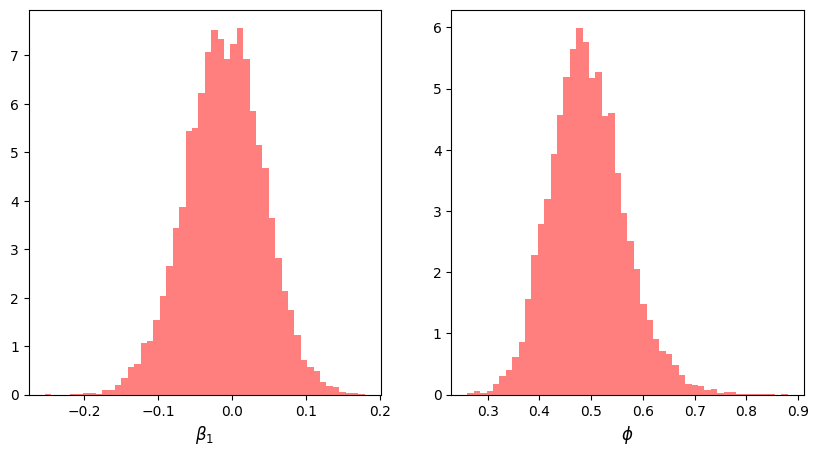

In [12]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
from progressbar import progressbar

# Transform data
def filter(data, phi):
    p = len(phi)
    T, k = data.shape
    data2 = np.zeros((T - p, k))
    for t in range(T - p):
        data2[t, :] = data[t + p, :]
        for j in range(p):
            data2[t, :] -= phi[j] * data[t + p - j - 1, :]
    return data2

# Regression with AR errors
def ar_err(y, x, s, beta0, B0, nu0, delta0, phi0, Phi0):
    # Initialization
    p = len(phi0)
    T, k = x.shape
    sample = {'beta': np.zeros((s, k)), 'sig2': np.zeros((s, 1)), 'phi': np.zeros((s, p))}
    sample['beta'][0, :] = beta0
    sample['sig2'][0] = delta0 / 2 / (nu0 / 2 - 1)
    sample['phi'][0, :] = phi0
    nu1 = nu0 + k + T - p
    
    # Sampling
    for i in progressbar(range(1, s)):
        # Sample beta
        y2 = filter(y, sample['phi'][i - 1, :])
        x2 = filter(x, sample['phi'][i - 1, :])
        B1 = np.linalg.inv(np.linalg.inv(B0) + x2.T @ x2)
        beta1 = B1 @ (np.linalg.inv(B0) @ beta0.reshape(-1, 1) + x2.T @ y2)
        sample['beta'][i, :] = stats.multivariate_normal.rvs(size=1, mean=beta1.ravel(), cov=B1)

        # Sample sig2
        err2 = y2 - x2 @ sample['beta'][i, :].reshape(-1, 1)
        delta1 = delta0 + (sample['beta'][i, :].reshape(1, -1) - beta0.reshape(1, -1)) @ np.linalg.inv(B0) @ (sample['beta'][i, :].reshape(-1, 1) - beta0.reshape(-1, 1)) + err2.T @ err2
        sample['sig2'][i] = stats.invgamma.rvs(nu1 / 2, size=1, scale=delta1 / 2)

        # Sample phi
        err = y - x @ sample['beta'][i, :].reshape(-1, 1)
        E = np.zeros((T - p, p))
        for t in range(T - p):
            for j in range(p):
                E[t, j] = err[t + p - j - 1]
        if Phi0.shape[0] == 1:
            Phi1 = 1 / (1 / Phi0 + E.T @ E / sample['sig2'][i])
            phi1 = Phi1 * (1 / Phi0 * phi0 + E.T @ err[p:].reshape(-1, 1) / sample['sig2'][i])
        else:
            Phi1 = np.linalg.inv(np.linalg.inv(Phi0) + E.T @ E / sample['sig2'][i])
            phi1 = Phi1 @ (np.linalg.inv(Phi0) @ phi0.reshape(-1, 1) + E.T @ err[p:].reshape(-1, 1) / sample['sig2'][i])
        sample['phi'][i, :] = stats.multivariate_normal.rvs(size=1, mean=phi1.ravel(), cov=Phi1)
        
    return sample

# Import data
with open("phillips.csv", "r") as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

data = np.array([row[1:] for row in data], dtype=float)
begin = 623
y = data[begin:, header.index('DInfl') - 1].reshape(-1, 1)
x = np.zeros((len(y), 2))
x[:, 0] = 1
x[:, 1] = data[begin:, header.index('Unemp') - 1]

# Prior and posterior
beta0 = np.array([0, 0])
B0 = np.identity(2)
nu0 = 5
delta0 = 5
phi0 = np.array([0.5])
Phi0 = np.array([0.15])
s = 11000
burn = 1000
sample = ar_err(y, x, s, beta0, B0, nu0, delta0, phi0, Phi0)
sample['beta'] = sample['beta'][burn:s, :]
sample['phi'] = sample['phi'][burn:s, :]
sample['sig2'] = sample['sig2'][burn:s]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(sample['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
ax1.set_xlabel(r'$\beta_1$', fontsize=12)
ax2.hist(sample['phi'], bins=50, density=True, color="red", alpha=0.5)
ax2.set_xlabel(r'$\phi$', fontsize=12)
plt.show()